## Objective
Simulate a real time experiment by replaying an organoid recording. Find how long it takes for prop to detect it

# TODO
Needs to work on any number of coactivations (right now, only works for 2)

In [1]:
# region Set up notebook imports
%load_ext autoreload
%autoreload
# Allow for imports of other scripts
import sys
IMPORTS_PATH = "/data/MEAprojects/PropSignal"
if IMPORTS_PATH not in sys.path:
    sys.path.append(IMPORTS_PATH)
# Reload a module after changes have been made
from importlib import reload
# endregion

from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
import scipy

from scipy.signal import find_peaks

from src.sorters.prop_signal import PropSignal
from src.recording import Recording
from src import utils

## Setup

In [8]:
RECORDING = Recording(utils.PATH_REC_SI)
PROP_SIGNAL = PropSignal("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230423", RECORDING)
THRESH_CROSSINGS = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_5_full/crossings.npy", allow_pickle=True)

In [9]:
# class BandpassFilter:
#     """
#     From SpikeInterface
#
#     Generic filter class based on:
#       * scipy.signal.iirfilter
#       * scipy.signal.filtfilt or scipy.signal.sosfilt
#     BandpassFilterRecording is built on top of it.
#
#     Parameters
#     ----------
#     band: int or tuple or list
#         If int, cutoff frequency in Hz for 'highpass' filter type
#         If list. band (low, high) in Hz for 'bandpass' filter type
#     sf: int
#         Sampling frequency of traces to be filtered (kHz)
#     btype: str
#         Type of the filter ('bandpass', 'highpass')
#     margin_ms: float
#         Margin in ms on border to avoid border effect
#     filter_mode: str 'sos' or 'ba'
#         Filter form of the filter coefficients:
#         - second-order sections (default): 'sos'
#         - numerator/denominator: 'ba'
#     coeff: ndarray or None
#         Filter coefficients in the filter_mode form.
#     """
#
#     def __init__(self, band=(300, 6000), sf=20000, btype="bandpass",
#                  filter_order=5, ftype="butter", filter_mode="sos", margin_ms=5.0,
#                  coeff=None):
#         assert filter_mode in ("sos", "ba")
#         if coeff is None:
#             assert btype in ('bandpass', 'highpass')
#             # coefficient
#             if btype in ('bandpass', 'bandstop'):
#                 assert len(band) == 2
#                 Wn = [e / sf * 2 for e in band]
#             else:
#                 Wn = float(band) / sf * 2
#             N = filter_order
#             # self.coeff is 'sos' or 'ab' style
#             filter_coeff = scipy.signal.iirfilter(N, Wn, analog=False, btype=btype, ftype=ftype, output=filter_mode)
#         else:
#             filter_coeff = coeff
#             if not isinstance(coeff, list):
#                 if filter_mode == 'ba':
#                     coeff = [c.tolist() for c in coeff]
#                 else:
#                     coeff = coeff.tolist()
#
#         margin = int(margin_ms * sf / 1000.)
#
#         self.coeff = filter_coeff
#         self.filter_mode = filter_mode
#         self.margin = margin
#
#     def __call__(self, trace):
#         # if self.filter_mode == "sos":
#         #     filtered = scipy.signal.sosfiltfilt(self.coeff, trace, axis=-1)
#         # elif self.filter_mode == "ba":
#         #     b, a = self.coeff
#         #     filtered = scipy.signal.filtfilt(b, a, trace, axis=-1)
#         # return filtered
#         return scipy.signal.sosfiltfilt(self.coeff, trace, axis=-1)
#
# filter_coeff = BandpassFilter((300, 3000), sf=30000).coeff
# # scipy.signal.sosfiltfilt(filter_coeff, trace, axis=-1)
#
# # Define the filter parameters
# order = 5  # Filter order
# fs = 30000  # Sample rate (Hz)
# low_freq = 300  # Lower cutoff frequency (Hz)
# high_freq = 3000  # Upper cutoff frequency (Hz)
#
# # Compute the filter coefficients
# nyquist = 0.5 * fs
# low = low_freq / nyquist
# high = high_freq / nyquist
# b, a = scipy.signal.butter(order, [low, high], btype='band')
#
# # Initialize filter state
# zi = scipy.signal.lfilter_zi(b, a)
# data_stream = RECORDING.get_traces_raw(100, 140)[100]
#
# filtered_data = []
# for data in data_stream:
#     filtered_data_point, zi = scipy.signal.lfilter(b, a, [data], zi=zi)
#     filtered_data.append(filtered_data_point[0])
# plt.plot(data_stream)
# plt.plot(filtered_data)
# plt.plot(scipy.signal.sosfiltfilt(filter_coeff, data_stream, axis=-1))
# plt.show()

In [10]:
thresh_crossings = {}  # {cross_time: [elecs with crossing]}
for elec, crossings in enumerate(THRESH_CROSSINGS):
    for cross in crossings:
        if cross not in thresh_crossings:
            thresh_crossings[cross] = [elec]
        else:
            thresh_crossings[cross].append(elec)
thresh_crossing_times = sorted(list(thresh_crossings.keys()))

## Start simulation

In [11]:
# In ms
MAX_DURATION = 0.5
ISI_VIOL = 1.5

In [12]:
# Keep track of latest threshold crossing on first electrode of each propagation
propagations = {elec: -np.inf for elec in range(RECORDING.get_num_channels())}  # Faster to have one for every electrode (more than number of props)

# Keep track of last detected spike for prop (prevents ISI violations of merged propagations)
last_detected_spikes = {}
for prop in PROP_SIGNAL:
    last = [-np.inf]  # Use array since passed by reference
    for df in prop.df:
        last_detected_spikes[df.ID[0]] = last

# Go from an electrode with thresh crossing to props with that electrode
elec_to_prop = {elec: [] for elec in range(RECORDING.get_num_channels())}  # Go from an electrode with thresh crossing to props with that electrode
for prop in PROP_SIGNAL:
    for df in prop.df:
        first_elec = df.ID[0]
        for elec in df.ID[1:]:
            elec_to_prop[elec].append(first_elec)

detected_spikes = []

processing_time = thresh_crossing_times[0]
for time in thresh_crossing_times:
    electrode_crossings = thresh_crossings[time]
    processing_end = None
    if time < processing_time:
        add_time = processing_time - time
    else:
        add_time = 0
        processing_time = time
    processing_start = perf_counter()
    for elec in electrode_crossings:
        propagations[elec] = time  # Faster to just set value than use an if-statement

    for elec in electrode_crossings:
        first_elecs = elec_to_prop[elec]
        for first_elec in first_elecs:
            first_time = propagations[first_elec]
            if time - first_time <= MAX_DURATION and first_time - last_detected_spikes[first_elec][0] > ISI_VIOL:
                propagations[first_elec] = -np.inf
                last_detected_spikes[first_elec][0] = first_time
                processing_end = perf_counter()

                add_start = perf_counter()
                detected_spikes.append((
                    time, first_time,
                    (processing_end - processing_start)*1000 + (time - first_time) + add_time
                ))
                add_end = perf_counter()
                processing_start += add_end - add_start

    processing_end_2 = perf_counter()
    if processing_end is None:
        processing_end = processing_end_2

    processing_time += (processing_end - processing_start) * 1000

In [13]:
len(detected_spikes) / sum(len(prop) for prop in PROP_SIGNAL)

0.9792289063524152

In [14]:
def get_matching_spikes(times1, times2, delta=0.4):
    matched = []
    unmatched1 = []

    already_matched = set()
    from tqdm import tqdm
    for st1 in tqdm(times1):
        idx = np.searchsorted(times2, st1)
        idx_left = idx - 1
        while idx_left in already_matched:
            idx_left -= 1
        if idx_left >= 0:
            left = times2[idx_left]
        else:
            left = -np.inf

        idx_right = idx
        while idx_right in already_matched:
            idx_right += 1
        if idx_right < len(times2):
            right = times2[idx_right]
        else:
            right = np.inf

        if right - st1 < st1 - left:
            if right - st1 <= delta:
                matched.append(st1)
                already_matched.add(idx_right)
            else:
                unmatched1.append(st1)
        else:
            if st1 - left <= delta:
                matched.append(st1)
                already_matched.add(idx_left)
            else:
                unmatched1.append(st1)

    unmatched2 = [times2[i] for i in range(len(times2)) if i not in already_matched]

    return matched, unmatched1, unmatched2

In [15]:
detected_spikes_sanity = sorted(st[0] for st in detected_spikes)
spikes_prop = np.sort(np.concatenate([prop.spike_train for prop in PROP_SIGNAL]))

In [16]:
matched, unmatched1, unmatched2 = get_matching_spikes(detected_spikes_sanity, spikes_prop, delta=0.8)#  / len(detected_spikes_sanity)

100%|██████████| 1135412/1135412 [00:06<00:00, 189122.74it/s]


In [17]:
len(matched)

1123240

In [18]:
len(unmatched1)

12172

In [19]:
len(unmatched2)

36256

In [20]:
len(matched) / len(spikes_prop)

0.9687312418499072

## Plot

In [21]:
from src import plot

In [22]:
detection_delays = [ds[2] for ds in detected_spikes]
detection_delays_inst = [ds[2] - (ds[0] - ds[1]) for ds in detected_spikes]
prop_delays = [ds[0] - ds[1] for ds in detected_spikes]

In [23]:
np.sum(np.array(detection_delays_inst) >= 0.03) / len(detection_delays_inst)

1.585327616759379e-05

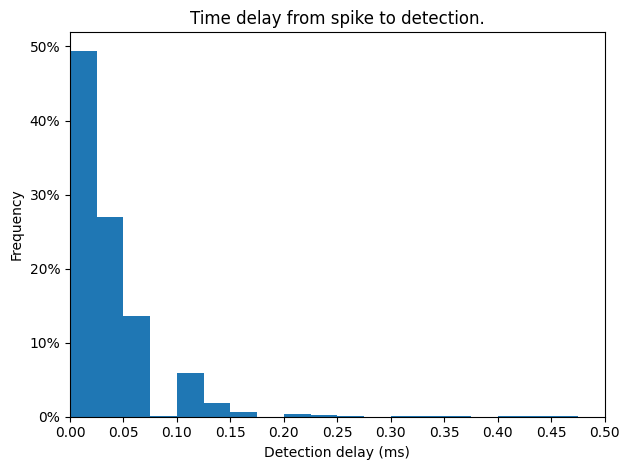

In [24]:
plot.plot_hist_percents(detection_delays, range=(0, MAX_DURATION), bins=20)
plt.xlim(0, MAX_DURATION)
plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
plt.xlabel("Time delay (ms)")
plt.title("Time delay from spike to detection.")
plt.tight_layout()
plt.show()

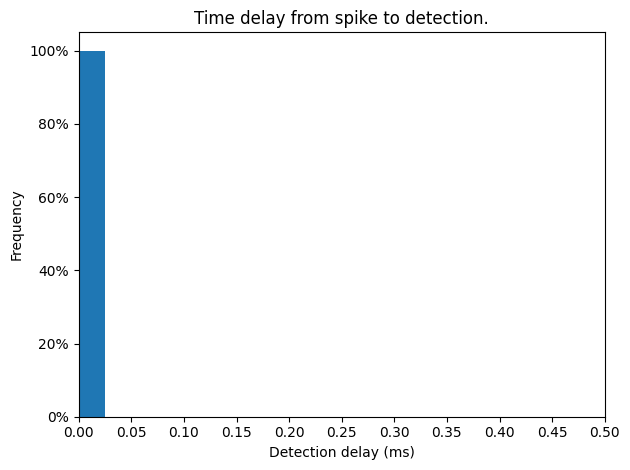

In [32]:
plot.plot_hist_percents(detection_delays_inst, range=(0, MAX_DURATION), bins=20)
plt.xlim(0, MAX_DURATION)
plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
plt.xlabel("Time delay (ms)")
plt.title("Time delay from spike to detection.")
plt.tight_layout()
plt.show()

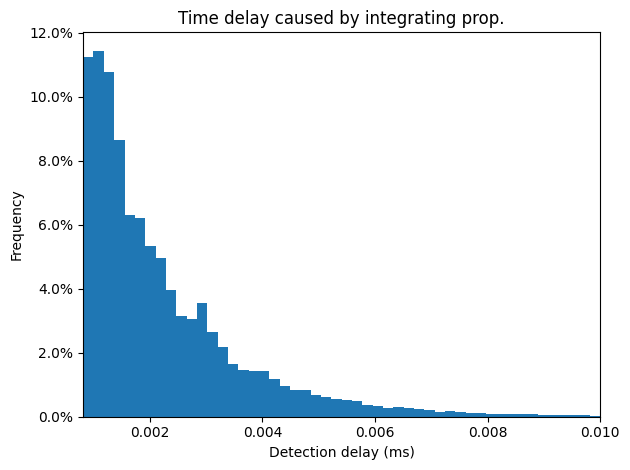

In [30]:
plot.plot_hist_percents(detection_delays_inst, bins=50, range=(min(detection_delays_inst), 0.01))
plt.xlim(min(detection_delays_inst), 0.01)
plt.xlabel("Time delay (ms)")
plt.title("Time delay caused by integrating prop.")
plt.tight_layout()
plt.show()
plt.show()

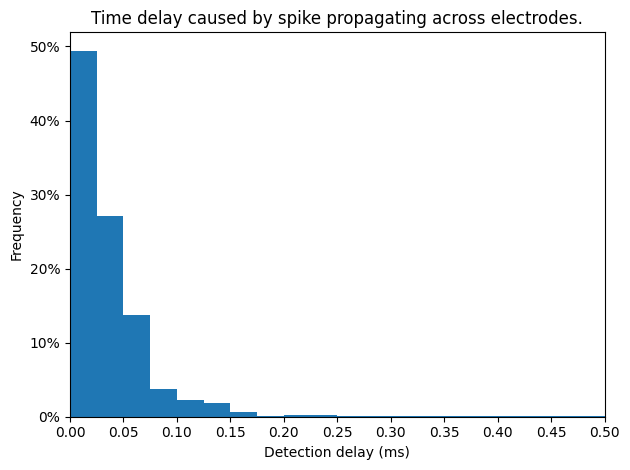

In [29]:
plot.plot_hist_percents(prop_delays, bins=20)
plt.xlim(0, MAX_DURATION)
plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
plt.xlabel("Detection delay (ms)")
plt.title("Time delay caused by spike propagating across electrodes.")
plt.tight_layout()
plt.show()

## Speed when using .py (not running through jupyter) is faster
Running from IPython (console) is probably faster than through IDE